# Imports


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load expression matrix

In [6]:
expr = pd.read_csv(
    "GSE315549_expression.txt.gz",
    sep="\t",
    compression="gzip",
    encoding="utf-16"
)
expr.head()

,Gene_ID,ABT_1:fpkm,ABT_2:fpkm,ABT_3:fpkm,Comb_1:fpkm,Comb_2:fpkm,Comb_3:fpkm,DMSO_1:fpkm,DMSO_2:fpkm,DMSO_3:fpkm,ELI_1:fpkm,ELI_2:fpkm,ELI_3:fpkm
0,ENSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSG00000000419,6.548102,6.098928,5.800998,7.570635,7.591704,7.580244,7.526411,6.091948,7.029755,8.434015,7.649289,7.772569
3,ENSG00000000457,1.948499,1.642256,1.193169,1.875497,1.971129,1.737105,2.129631,1.575788,1.577768,2.240891,2.208444,1.977816
4,ENSG00000000460,4.146023,4.074541,4.261959,1.824998,1.456780,1.653344,4.299233,3.816057,3.803484,3.021965,3.000861,2.749056


# Identify and extract HSPA5

In [7]:
HSPA5_ID = "ENSG00000044574"

hspa5_row = expr[expr["Gene_ID"] == HSPA5_ID]

if hspa5_row.empty:
    raise ValueError("HSPA5 not found in expression matrix")

hspa5_row


,Gene_ID,ABT_1:fpkm,ABT_2:fpkm,ABT_3:fpkm,Comb_1:fpkm,Comb_2:fpkm,Comb_3:fpkm,DMSO_1:fpkm,DMSO_2:fpkm,DMSO_3:fpkm,ELI_1:fpkm,ELI_2:fpkm,ELI_3:fpkm
602,ENSG00000044574,93.294693,88.876695,86.478303,135.289969,133.032691,136.258268,91.263041,85.862379,92.020065,133.740339,130.250339,136.430163


# Clean column names & reshape data

In [8]:
# Drop Gene_ID column
hspa5_expr = hspa5_row.drop(columns=["Gene_ID"]).T
hspa5_expr.columns = ["FPKM"]

# Extract condition from column names
hspa5_expr["Condition"] = hspa5_expr.index.str.split("_").str[0]

hspa5_expr.head()

,FPKM,Condition
ABT_1:fpkm,93.294693,ABT
ABT_2:fpkm,88.876695,ABT
ABT_3:fpkm,86.478303,ABT
Comb_1:fpkm,135.289969,Comb
Comb_2:fpkm,133.032691,Comb


# Log2 normalization (correct for FPKM)

In [9]:
hspa5_expr["log2_FPKM"] = np.log2(hspa5_expr["FPKM"] + 1)

# Aggregate replicates (mean ± SD)

In [21]:
labels = {
    "DMSO": "DMSO (Control)",
    "ABT": "ABT (Venetoclax)",
    "ELI": "ELI (Eliglustat)",
    "Comb": "Combination"
}

summary = (
    hspa5_expr
    .groupby("Condition")["log2_FPKM"]
    .agg(mean="mean", std="std")
    .reset_index()
    .assign(Condition=lambda d: pd.Categorical(d["Condition"], labels, ordered=True))
    .sort_values("Condition")
)

summary["Condition"] = summary["Condition"].map(labels)
summary

,Condition,mean,std
2,DMSO (Control),6.502604,0.053968
0,ABT (Venetoclax),6.499944,0.054824
3,ELI (Eliglustat),7.070923,0.033298
1,Combination,7.085909,0.017616


# Barplot – HSPA5 expression across conditions

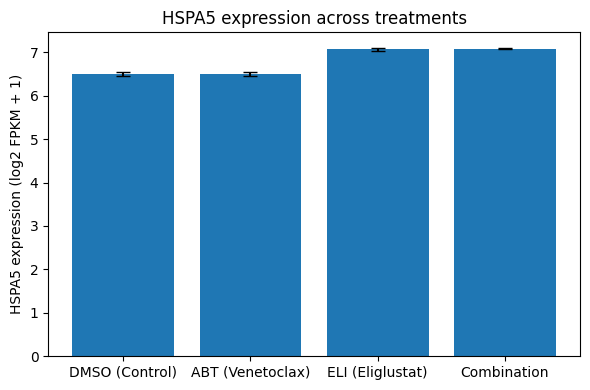

In [22]:
plt.figure(figsize=(6,4))

plt.bar(
    summary["Condition"],
    summary["mean"],
    yerr=summary["std"],
    capsize=5
)

plt.ylabel("HSPA5 expression (log2 FPKM + 1)")
plt.title("HSPA5 expression across treatments")
plt.tight_layout()
plt.show()


In [34]:
# Define ER-stress genes
ER_genes = {
    "HSPA5": "ENSG00000044574",
    "XBP1":  "ENSG00000100219",
    "ATF4":  "ENSG00000128272",
    "DDIT3": "ENSG00000175197"  # CHOP
}

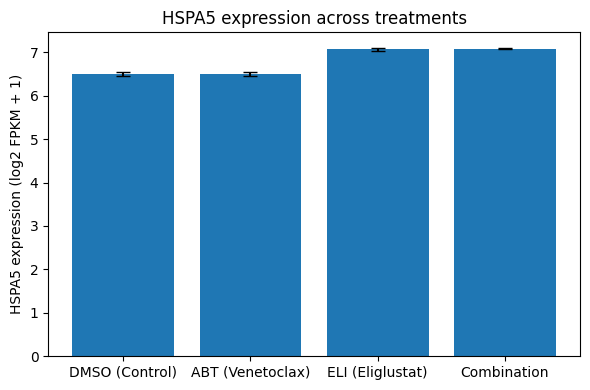

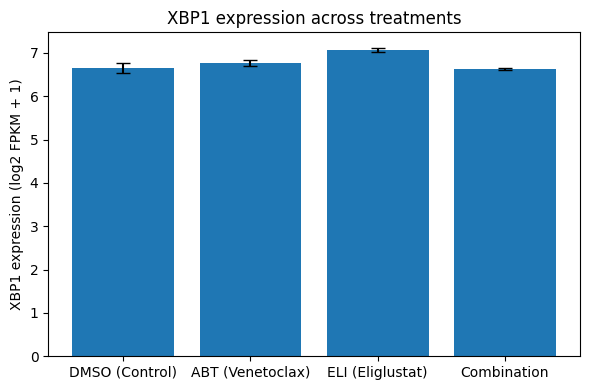

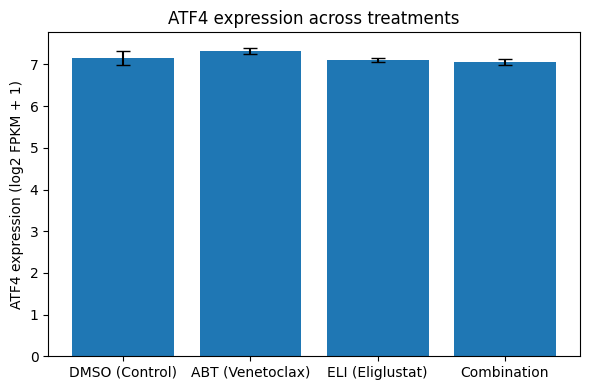

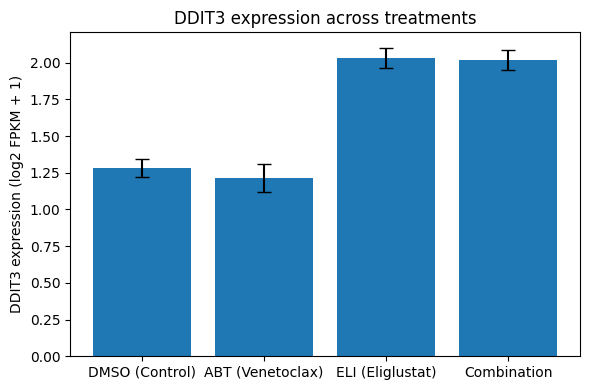

In [35]:
for gene, gene_id in er_genes.items():

    row = expr[expr["Gene_ID"] == gene_id]
    if row.empty:
        print(f"{gene} not found, skipping")
        continue

    df = row.drop(columns="Gene_ID").T
    df.columns = ["FPKM"]
    df["Condition"] = df.index.str.split("_").str[0]
    df["log2_FPKM"] = np.log2(df["FPKM"] + 1)

    summary = (
        df.groupby("Condition")["log2_FPKM"]
        .agg(mean="mean", std="std")
        .reset_index()
        .assign(Condition=lambda d: pd.Categorical(d["Condition"], labels, ordered=True))
        .sort_values("Condition")
    )

    summary["Condition"] = summary["Condition"].map(labels)

    # PLOT — must stay indented (inside loop)
    plt.figure(figsize=(6,4))
    plt.bar(summary["Condition"], summary["mean"], yerr=summary["std"], capsize=5)
    plt.ylabel(f"{gene} expression (log2 FPKM + 1)")
    plt.title(f"{gene} expression across treatments")
    plt.tight_layout()
    plt.show()


# ER-stress heatmap


In [38]:
# Same labels and order as barplots
order = ["DMSO", "ABT", "ELI", "Comb"]
labels = {
    "DMSO": "DMSO (Control)",
    "ABT": "ABT (Venetoclax)",
    "ELI": "ELI (Eliglustat)",
    "Comb": "Combination"
}

# Extract ER-stress genes
er_expr = (
    expr[expr["Gene_ID"].isin(er_genes.values())]
    .set_index("Gene_ID")
    .rename(index={v: k for k, v in er_genes.items()})
    .T
)

# Add condition
er_expr["Condition"] = er_expr.index.str.split("_").str[0]
er_expr["Condition"] = pd.Categorical(er_expr["Condition"], order, ordered=True)

# Log2(FPKM + 1)
er_log = np.log2(er_expr.drop(columns="Condition") + 1)

# Average replicates per condition
er_mean = (
    er_log
    .assign(Condition=er_expr["Condition"])
    .groupby("Condition")
    .mean()
)

# Rename conditions for display
er_mean.index = er_mean.index.map(labels)

# Z-score per gene (row-wise, for heatmap only)
er_z = (er_mean - er_mean.mean()) / er_mean.std()

/tmp/ipython-input-2575010872.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Condition")


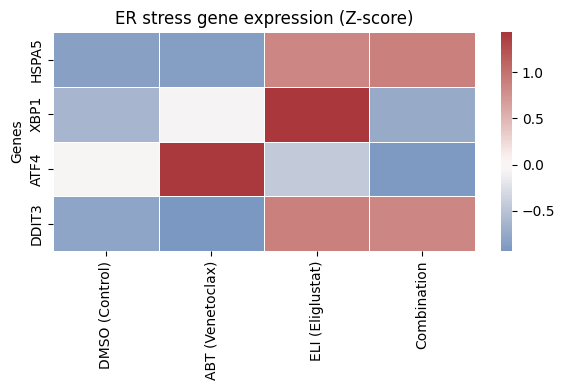

In [39]:
# Heatmap
plt.figure(figsize=(6,4))

sns.heatmap(
    er_z.T,
    cmap="vlag",
    center=0,
    linewidths=0.5
)

plt.title("ER stress gene expression (Z-score)")
plt.xlabel("")
plt.ylabel("Genes")

plt.tight_layout()
plt.show()
